In [2]:
import numpy as np
from tensorflow.python.keras import models, layers, optimizers
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import bz2
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt 
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import pandas as pd

2021-08-13 18:19:02.577819: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-13 18:19:02.577866: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Load data
dataset = pd.read_csv('/projects/250c93cf-311b-4af0-b0c9-a55b21af396c/Fernanda/hate-speech-and-offensive-language/data/labeled_data.csv')

In [4]:
hate_filter = dataset['class']==1

In [5]:
hate_speech = dataset[hate_filter]


In [6]:
# grab labels
labels = dataset['class'].values

In [7]:
# grab tweets
tweets = dataset['tweet'].astype(str).tolist()

In [8]:
# preprocessing: get rid of special chars, 'rt', spaces and lowercase

space_pattern = '\s+'
giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
mention_regex = '@[\w\-]+'
number_regex = r'\b\d+\b' #removes numbers
another_regex = '[^A-Za-z0-9]' #removes special characters

def normalize_texts(texts):
    normalized_texts = []
    for text in texts:
        lower = text.lower()
        parsed_text = re.sub(space_pattern, ' ', lower)
        parsed_text = re.sub(giant_url_regex, '', parsed_text)
        parsed_text = re.sub(mention_regex, '', parsed_text)
        parsed_text = re.sub(another_regex, ' ', parsed_text)
        parsed_text = re.sub(number_regex, '', parsed_text)
        parsed_text = parsed_text.replace('rt','').replace('amp','')
        parsed_text = parsed_text.strip()
        normalized_texts.append(parsed_text)
        
    return normalized_texts

In [9]:
# apply preprocessing to our data
train = normalize_texts(tweets)

In [10]:
# Vectorize text data using count vectorizer
cv = CountVectorizer()
cv.fit(train)
X = cv.transform(train)

In [11]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, labels, train_size = 0.75)


In [ ]:
X_train[0]

## Classification

In [12]:
## Logistic Regression Classifer
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_test, lr.predict(X_test))))      # previously: y_test, x_test

Accuracy for C=0.01: 0.8642672692059393
Accuracy for C=0.05: 0.8957391865719819


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy for C=0.25: 0.9017107811491285


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy for C=0.5: 0.9005810200129115
Accuracy for C=1: 0.8992898644286637


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Evaluate the Model

In [ ]:
# Get predictions
y_pred = lr.predict(X_test)

In [ ]:
### Log Regression Confusion Matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(lr, X_test,y_test)
plt.show()


In [54]:
### SVM Classifier 

#Import svm model
from sklearn import svm

#Create a svm Classifier
svm_classifier = svm.SVC(kernel='rbf') # Linear Kernel

#Train the model using the training sets
svm_classifier.fit(X_train, y_train)



SVC()

In [55]:
accuracy_score(y_test, svm_classifier.predict(X_test))

0.907198192382182

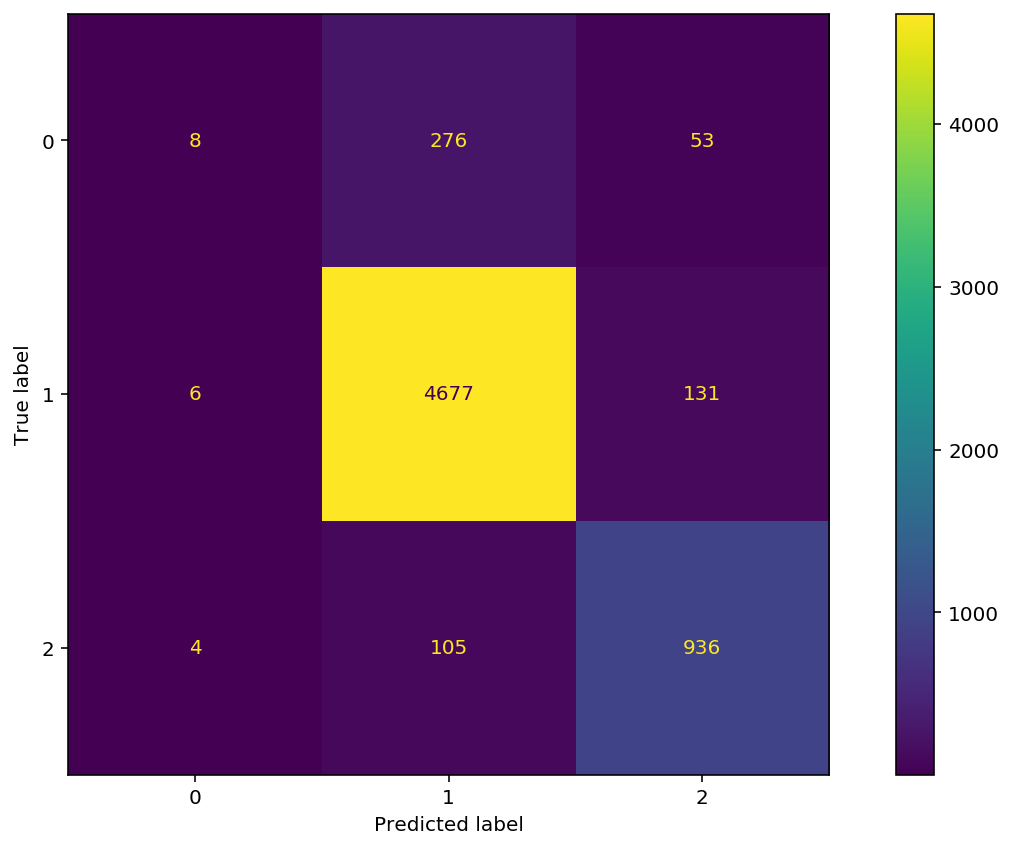

In [56]:
plot_confusion_matrix(svm_classifier, X_test,y_test)
plt.show()


In [57]:
#Predict the response for test dataset (input)
y_pred = svm_classifier.predict(X_test)

# Model Accuracy
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.907198192382182


In [58]:
## Saves trained model
import pickle

# filename = 'hate_log_reg_model.pkl'
filename = 'hate_cv.pkl'
pickle.dump(cv, open(filename, 'wb'))

In [59]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb


clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=3)

grid.fit(X_train, y_train)

/projects/250c93cf-311b-4af0-b0c9-a55b21af396c/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/projects/250c93cf-311b-4af0-b0c9-a55b21af396c/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/projects/250c

[22:07:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:09:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:12:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

/projects/250c93cf-311b-4af0-b0c9-a55b21af396c/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/projects/250c93cf-311b-4af0-b0c9-a55b21af396c/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/projects/250c

In [ ]:
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

In [ ]:
# XGBoost Model
! pip install xgboost

In [ ]:
# XGBoost Model: preparing data
from sklearn import datasets
import xgboost as xgb

# Transfering x train and x test data to numpy array (y data is already a numpy array)
X_train_array = X_train.toarray(order=None, out=None)
X_test_array = X_test.toarray(order=None, out=None)

# Transferring numpy array to DMatrix
D_train = xgb.DMatrix(X_train_array, label = y_train)
D_test = xgb.DMatrix(X_test_array, label = y_test)

In [ ]:
D_test

In [ ]:
# XGBoost Model: defining parameters
param = {
    'eta': 0.3,
    'max_depth': 3,
    'objective': 'multi:softprob',
    'num_class': 3}

steps = 100 # The number of training iterations

In [ ]:
# XGBoost Model: training model
model = xgb.train(param, D_train, steps)

In [ ]:
# XGBoost Model: run evaluation
from sklearn.metrics import precision_score, recall_score, accuracy_score

preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

# print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
# print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
# print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

In [ ]:
### Deep Neural Network Classifier 3

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.utils import np_utils

# one hot encode labels
dummy_y = np_utils.to_categorical(labels)

X_train, X_val, y_train, y_val = train_test_split(X, dummy_y, train_size = 0.75)

# Build model
model = Sequential()
model.add(layers.Dense(10, input_dim=X_train.shape[1], activation='relu'))
model.add(layers.Dense(1000, input_dim=X_train.shape[1], activation='relu'))
model.add(layers.Dense(50, input_dim=X_train.shape[1], activation='relu'))
model.add(layers.Dense(10, input_dim=X_train.shape[1], activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model summary
model.summary()

In [ ]:
# Train model
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_val, y_val), 
                    batch_size=32)

loss, accuracy = model.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val, y_val, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))


### Test the Model with Examples

In [ ]:
# TEST
normalized_review = []
review = ['']
cleaned_texts = normalize_texts(review)
cleaned_texts = cv.transform(cleaned_texts)

prediction=svm_classifier.predict(cleaned_texts)
# prediction=np.argmax(model.predict(cleaned_texts), axis=-1)

output=""
if prediction[0]==0:
    output="hate speech"

elif prediction[0]==1:
    output="off lang"
else:
    output = 'neither'
    
print(output)

In [ ]:
X_train.shape[1]

In [ ]:
##################################################################################################################################################

## Save model with greatest accuracy

In [ ]:
## Saves trained model
import pickle

filename = 'log_reg_model.pkl'
pickle.dump(lr, open(filename, 'wb'))